# Game Analysis: Do Harder Levels Cause Player Churn?

# Motivation

Generally, high game difficulty may reduce players’ willingness to engage with the game. However, in reality, the situation is more complex. Different people have different reactions to difficult levels — some may quit easily, while others persist. In addition, players who share certain characteristics may be more active on social media and spread negative messages, which can distort the perception of the actual gameplay experience. This may hide the true user experience. Therefore, it is important to investigate players’ real experiences and evaluate the game design fairly — is the level truly too difficult and causing churn, or is the outcome driven by a minority of users who introduce bias on social media?

Intuitively, we can stratify users into personas and examine their churn patterns using causal inference. Technically, we can first use the ATE to understand the overall impact, and then use the ITE to dive into each persona group and analyze their performance.

$$
\text{ATE} = \mathbb{E}[Y(1) - Y(0)]
$$

$$
\text{ITE}_i = Y_i(1) - Y_i(0)
$$

# Introduction

## Data Structure

Data is collected from various gaming platforms, capturing key player metrics and behaviors. For better aggregation, Player ID is removed.
Below is a brief description of each feature:

- **`attempts`**: Number of attempts the player made to pass the level.
- **`time_played`**: Total time the player spent in gameplay.
- **`booster_used`**: Number of boosters the player used.
- **`level_completion_time`**: Time taken by the player to complete the level.
- **`specific_action_usage`**: Usage count of specific in-game actions.
- **`lives_from_ads`**: Number of extra lives gained from watching ads.
- **`purchase_amount`**: Total amount of money the player spent.
- **`purchase_date`**: Timestamp of the player's in-game purchase.
- **`device_type`**: Type of device the player is using (e.g., iOS, Android).
- **`os_version`**: Operating system version of the player’s device.
- **`friend_invites_sent`**: Number of invitations the player sent to friends.
- **`friend_invites_received`**: Number of invitations the player received from friends.
- **`guild_chat_messages`**: Number of messages the player sent in guild chat.
- **`facebook_connect_status`**: Whether the player connected the game to Facebook.
- **`social_engagement_through_facebook`**: Level of engagement through Facebook (shares/posts).
- **`churn`**: Player churn indicator (1 = churned, 0 = active).
- **`hard_level`**: Whether the level is marked as “hard” (1 = hard, 0 = normal).

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("game_data.csv")
# Preview structure
df.head()

,attempts,time_played,booster_used,level_completion_time,specific_action_usage,lives_from_ads,purchase_amount,purchase_date,device_type,os_version,friend_invites_sent,friend_invites_received,guild_chat_messages,facebook_connect_status,social_engagement_through_facebook,churn,hard_level,purchase_month,ps
0,20,800,14,921,fish usage,28,20.30,2024-01-28,android,19.3,7,0,8,1,low,0,1,1.0,0.360325
1,23,17048,29,50,striped candy swipe,35,46.55,2024-01-28,android,17.6,1,20,11,0,low,0,0,1.0,0.232600
2,120,7581,17,1576,fish usage,0,23.49,2024-01-28,iphone,13.2,0,8,5,1,low,0,0,1.0,0.191815
3,269,4828,0,50,extra time boost,0,0.71,2024-01-28,ipad,14.7,1,20,61,0,low,0,1,1.0,0.234084
4,94,1331,18,398,special candy swap,9,4.41,2024-01-28,ipad,15.9,10,0,12,1,low,0,0,1.0,0.191177


## DAG Display

In order to understand the causal structure for how level difficulty affects player churn, a Directed Acyclic Graph (DAG) should be constructed.

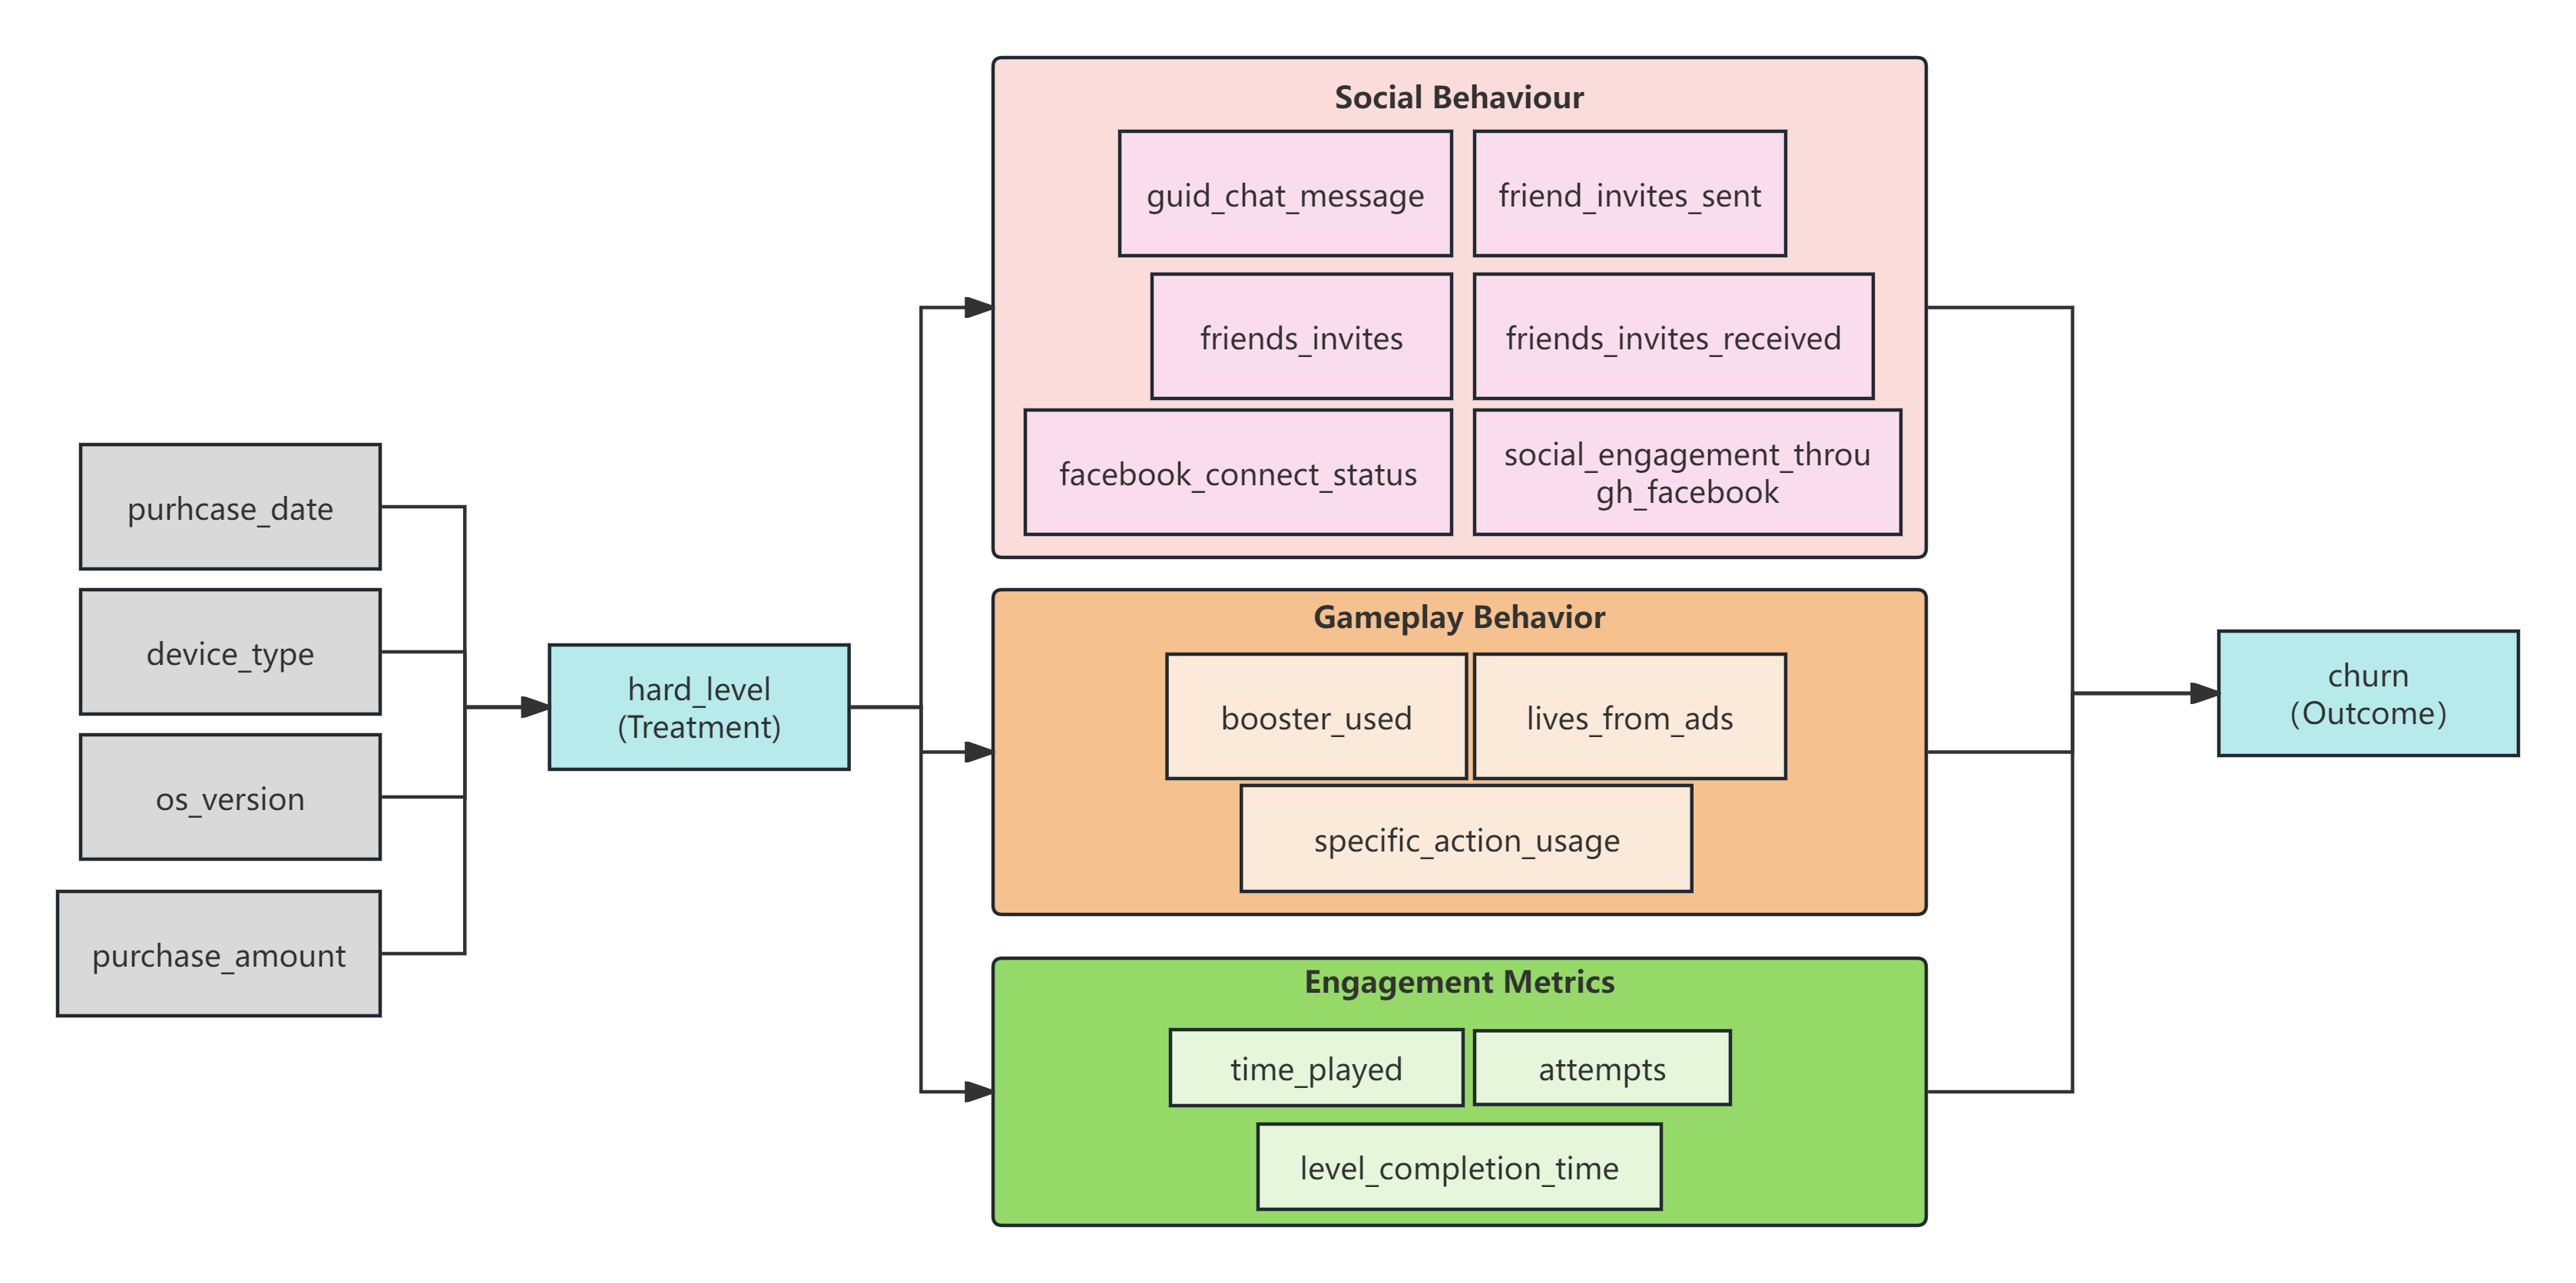

Typically, treatment, outcome, pre-treatments, post-treatments and confounders should be identified.

### Treatment

$$
T = \text{hard\_level} \in \{0,1\}
$$

T = 1： harder-than-usual level (treatment) 

T = 0： usual level (control) 

### Outcome

$$
Y = \text{churn} \in \{0,1\}
$$

Y = 1: the player churns (stops playing)

Y = 0: the player continues playing

### Adjustment Set

$$
\{\text{purchase\_date},\ device\_type,\ os\_version,\ purchase\_amount\}
$$


The treatment variable hard_level is influenced by pre-treatment variable, including device type, OS version, purchase behavior, and purchase timing. After players enter either a hard or normal level, their social interactions, gameplay behaviors, and engagement metrics evolve as a consequence of the treatment. These post-treatment variables can further affect the final outcome, churn.

This structure provides a guidance on variable adjustment. Since there are no obvious confounders, only pre-treatment variables should be controlled for. Post-treatment variables should be avoided, as adjusting for them may introduce bias.

## Casual Problem Set up

Do Harder Levels Cause Player Churn?
Do churn patterns differ across player groups?

## Identification Assumptions

### SUTVA

- **Positivity**: Each player has a non-zero probability of both encountering and not encountering a hard level.
- **Consistency**: The observed churn equals the potential outcome under the treatment actually received.
- **No interference**: One player's treatment does not directly affect another player's churn.

### Exchangeability

- **Conditional independence**:  
  Given covariates \(X\), treatment assignment is independent of potential outcomes:  
$$
A \perp \{Y(0), Y(1)\} \mid X
$$

- **Achieved via PSM**:  
  This condition is approximated by applying Propensity Score Matching (PSM) to balance treated and control groups.
  The propensity score is defined as:
  $$
  e(X) = \Pr(A=1 \mid X)
  $$

  Matching is performed by pairing treated and control units with similar propensity scores:
  $$
  \text{Match}(i) = \arg\min_{j \in \mathcal{C}} \; |\, e(X_i) - e(X_j) \,|
  $$

In [2]:
X = df[['purchase_amount', 'purchase_month','device_type','os_version']]
T = df['hard_level']

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# 1. Divide numerical and categorical variables
num_cols = ['purchase_amount']
cat_cols = ['purchase_month', 'device_type', 'os_version']

# 2. Preprocess: One hot encoder
preprocess = ColumnTransformer(
    transformers=[
#        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

# 3. Propensity Score model (logistic)
ps_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('logit', LogisticRegression(max_iter=1000))
])

# 4. Fitting PS Model
ps_model.fit(X, T)

# 5. Predict Propensity Score
df['ps'] = ps_model.predict_proba(X)[:, 1]
df[['ps']].head()

,ps
0,0.357358
1,0.227520
2,0.192229
3,0.233090
4,0.189470


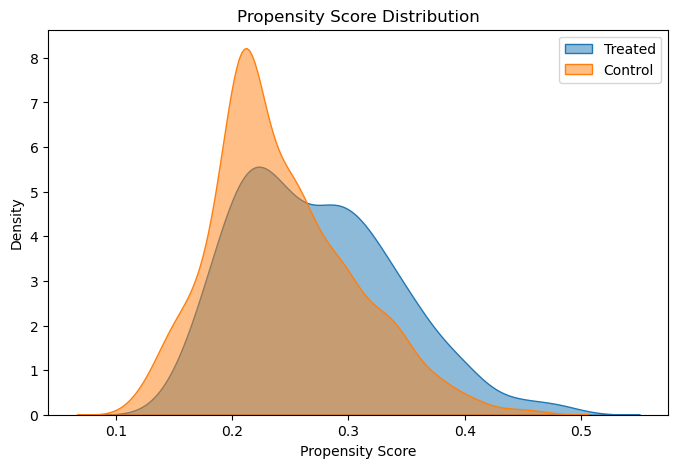

In [4]:
# Overlap Checking
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.kdeplot(df[df['hard_level']==1]['ps'], fill=True, label='Treated', alpha=0.5)
sns.kdeplot(df[df['hard_level']==0]['ps'], fill=True, label='Control', alpha=0.5)

plt.title("Propensity Score Distribution")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.show()

In [5]:
import pandas as pd
import numpy as np

treated = df[df['hard_level'] == 1].copy()
control = df[df['hard_level'] == 0].copy()

matched_pairs = []

for idx, row in treated.iterrows():
    ps_value = row['ps']
    
    # Find out the minimum gap
    nearest_idx = (control['ps'] - ps_value).abs().idxmin()
    matched_pairs.append((idx, nearest_idx))
    
    # Remove matched pairs
    control = control.drop(nearest_idx)

# Construct Matched dataframe
t_idx = [p[0] for p in matched_pairs]
c_idx = [p[1] for p in matched_pairs]

df_matched = pd.concat([df.loc[t_idx], df.loc[c_idx]], axis=0)
df_matched.shape

(1002, 19)

In [6]:
import numpy as np
import pandas as pd

def compute_smd(df, treat, cols):
    smd_list = {}
    for col in cols:
        if np.issubdtype(df[col].dtype, np.number):
            m1 = df[df[treat] == 1][col].mean()
            m0 = df[df[treat] == 0][col].mean()
            s1 = df[df[treat] == 1][col].std()
            s0 = df[df[treat] == 0][col].std()
            smd = (m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)
            smd_list[col] = smd
        else:
            dummies = pd.get_dummies(df[col], drop_first=True)
            for c in dummies.columns:
                m1 = dummies[df[treat] == 1][c].mean()
                m0 = dummies[df[treat] == 0][c].mean()
                s1 = dummies[df[treat] == 1][c].std()
                s0 = dummies[df[treat] == 0][c].std()
                smd = (m1 - m0) / np.sqrt((s1**2 + s0**2) / 2)
                smd_list[f"{col}_{c}"] = smd
    return pd.Series(smd_list)


In [7]:
import matplotlib.pyplot as plt

def love_plot(smd_before, smd_after):
    smd_df = pd.DataFrame({
        'Before Matching': smd_before.abs(),
        'After Matching': smd_after.abs()
    }).sort_values("Before Matching")

    plt.figure(figsize=(8,6))
    plt.plot(smd_df['Before Matching'], smd_df.index, "o", label="Before Matching")
    plt.plot(smd_df['After Matching'], smd_df.index, "o", label="After Matching")

    plt.axvline(0.1, color='red', linestyle='--', label="SMD = 0.1")
    plt.title("Love Plot")
    plt.xlabel("Standardized Mean Difference")
    plt.legend()
    plt.show()


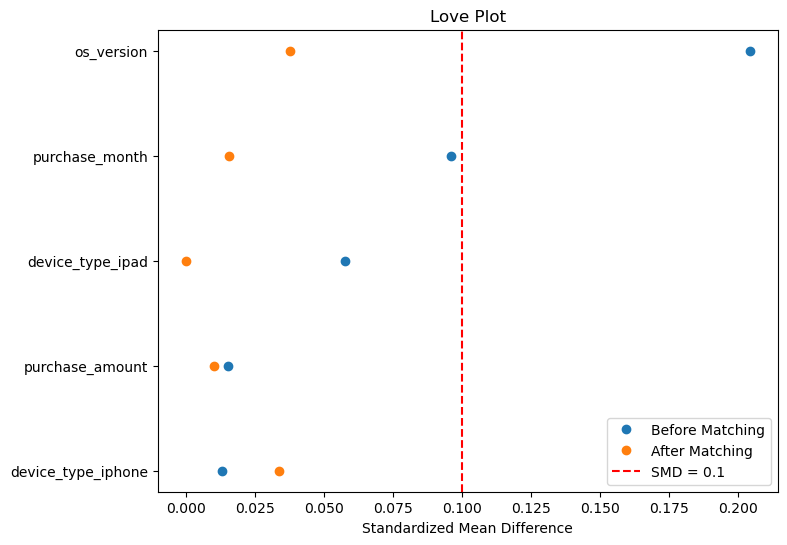

In [8]:
cols = ['purchase_amount', 'purchase_month','device_type','os_version']

smd_before = compute_smd(df, 'hard_level', cols)
smd_after = compute_smd(df_matched, 'hard_level', cols)

love_plot(smd_before, smd_after)

In [9]:
df_matched.head()

,attempts,time_played,booster_used,level_completion_time,specific_action_usage,lives_from_ads,purchase_amount,purchase_date,device_type,os_version,friend_invites_sent,friend_invites_received,guild_chat_messages,facebook_connect_status,social_engagement_through_facebook,churn,hard_level,purchase_month,ps
0,20,800,14,921,fish usage,28,20.30,2024-01-28,android,19.3,7,0,8,1,low,0,1,1.0,0.357358
3,269,4828,0,50,extra time boost,0,0.71,2024-01-28,ipad,14.7,1,20,61,0,low,0,1,1.0,0.233090
6,253,800,95,852,fish usage,0,5.40,2024-01-28,iphone,17.1,2,18,0,0,low,0,1,1.0,0.302535
7,4,800,7,290,special candy swap,8,5.23,2024-01-28,iphone,17.7,3,0,1,0,low,1,1,1.0,0.289307
24,4,15623,29,1043,extra time boost,0,7.06,2024-01-12,ipad,14.5,55,22,28,1,low,0,1,1.0,0.183926


The propensity score distribution shows a clear overlap. It indicates that players in both groups share comparable ranges of propensity scores.
Based on Love plot, the reduced standardized mean differences (SMDs) fall below the commonly accepted 0.1 threshold and most matched varaibles are closer than those before matched. Given the sufficient overlap and improved post-matching balance, the exchangeability assumption is met.

# Methods and Results

### ATE and ITE estimation based on DR

We introduce a **doubly robust (DR) estimator** to estimate both the ATE and unit-level effects (ITE). The DR framework combines two components:  
(1) a **propensity score model** describing treatment assignment, and  
(2) an **outcome regression model** predicting expected outcomes under each treatment condition.  

In our setting, the treatment \(T\) indicates whether the player encounters a hard level, the outcome \(Y\) is the churn indicator, and \(X\) represents all pre-treatment covariates. Let the estimated propensity score be  
$$
e(X) = \Pr(T=1 \mid X),
$$  
and let the outcome models be  
$$
m_t(X) = \mathbb{E}[Y \mid T=t, X], \quad t \in \{0,1\}.
$$

The **doubly robust estimator of the ATE** is given by:  
$$
\widehat{\text{ATE}}_{\text{DR}} =
\frac{1}{n} \sum_{i=1}^n 
\left[
\hat{m}_1(X_i) - \hat{m}_0(X_i)
+ \frac{T_i (Y_i - \hat{m}_1(X_i))}{\hat{e}(X_i)}
- \frac{(1-T_i)(Y_i - \hat{m}_0(X_i))}{1 - \hat{e}(X_i)}
\right].
$$

This estimator is called **doubly robust** because it remains consistent if **either** the propensity score model $\hat{e}(X)$ **or** the outcome models $\hat{m}_1(X)$ and $\hat{m}_0(X)$ are correctly specified — only one needs to be right, not both.

The outcome regression models also provide **individual treatment effects (ITE)** for each player:  
$$
\widehat{\tau}_i = \hat{m}_1(X_i) - \hat{m}_0(X_i),
$$  
which help us evaluate how the effect of encountering a hard level varies across individual players or player segments.

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


# ====================================================
# 1. Propensity Score Model (Random Forest Classifier)
# ====================================================

def fit_ps_model(X, A, num_cols, cat_cols):
    
    preprocess = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
            ('num', 'passthrough', num_cols)
        ]
    )

    ps_model = Pipeline(steps=[
        ('preprocess', preprocess),
        ('rf', RandomForestClassifier(
                n_estimators=300,
                max_depth=6,
                random_state=42))
    ])

    ps_model.fit(X, A)
    ps = ps_model.predict_proba(X)[:, 1]

    return ps_model, ps


# ====================================================
# 2. Outcome Models m1(X), m0(X)
# ====================================================

def fit_outcome_models(X, A, Y, num_cols, cat_cols):

    preprocess = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
            ('num', 'passthrough', num_cols)
        ]
    )

    # Treat outcome as probability → use RandomForestRegressor
    model_1 = Pipeline(steps=[
        ('preprocess', preprocess),
        ('rf', RandomForestRegressor(
                n_estimators=300,
                random_state=42))
    ])
    model_1.fit(X[A == 1], Y[A == 1])
    m1 = model_1.predict(X)

    model_0 = Pipeline(steps=[
        ('preprocess', preprocess),
        ('rf', RandomForestRegressor(
                n_estimators=300,
                random_state=42))
    ])
    model_0.fit(X[A == 0], Y[A == 0])
    m0 = model_0.predict(X)

    return m1, m0, model_1, model_0


# ====================================================
# 3. Doubly Robust Estimator
# ====================================================

def doubly_robust_ate(Y, A, ps, m1, m0):

    dr_scores = m1 - m0 + (A * (Y - m1)) / ps - ((1 - A) * (Y - m0)) / (1 - ps)

    ate = dr_scores.mean()
    se  = dr_scores.std() / np.sqrt(len(Y))

    return ate, se, dr_scores


# ====================================================
# 4. Full DR Pipeline
# ====================================================

def dr_pipeline(df, treatment_col, outcome_col, num_cols, cat_cols):

    X = df[num_cols + cat_cols]
    A = df[treatment_col].values
    Y = df[outcome_col].values

    # 1. PS model
    ps_model, ps = fit_ps_model(X, A, num_cols, cat_cols)

    # 2. outcome models
    m1, m0, model_1, model_0 = fit_outcome_models(X, A, Y, num_cols, cat_cols)

    # 3. DR ATE
    ate, se, dr_scores = doubly_robust_ate(Y, A, ps, m1, m0)

    return {
        'ate': ate,
        'se': se,
        'ITE': dr_scores,
        'ps': ps,
        'm1': m1,
        'm0': m0,
        'ps_model': ps_model,
        'outcome_model_1': model_1,
        'outcome_model_0': model_0
    }


In [11]:
result = dr_pipeline(
    df=df_matched,
    treatment_col='hard_level',
    outcome_col='churn',
    num_cols=['purchase_amount'],  
    cat_cols=['purchase_month', 'device_type', 'os_version']
)

print("DR ATE =", result['ate'])
print("Std Error =", result['se'])

DR ATE = 0.13273238023150197
Std Error = 0.022356810277263536


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ATE is 0.13 with a standard error of 0.022. It indicates a statistically significant effect. In practical terms, this means that encountering a hard level increases the probability of churn by about 13 percentage points on average, holding pre-treatment characteristics constant.

In [12]:
purchase_month_cats = sorted(df['purchase_month'].unique().tolist())
device_type_cats    = sorted(df['device_type'].unique().tolist())
os_version_cats     = sorted(df['os_version'].unique().tolist())


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

cat_cols = ['purchase_month', 'device_type', 'os_version']
num_cols = ['purchase_amount']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(
            categories=[purchase_month_cats, device_type_cats, os_version_cats],
            drop='first',
            handle_unknown='ignore'
        ), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

X = df[cat_cols + num_cols]
A = df['hard_level']
Y = df['churn']

rf_treated = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42))
])
rf_treated.fit(X[A==1], Y[A==1])

rf_control = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42))
])
rf_control.fit(X[A==0], Y[A==0])

p1 = rf_treated.predict_proba(X)[:, 1]
p0 = rf_control.predict_proba(X)[:, 1]

df['tau_hat'] = p1 - p0


In [13]:
# Predict potential outcomes
mu1 = rf_treated.predict_proba(X)[:,1]
mu0 = rf_control.predict_proba(X)[:,1]

df['mu1_hat'] = mu1
df['mu0_hat'] = mu0

# Compute Individual Treatment Effect
df['ITE'] = df['mu1_hat'] - df['mu0_hat']

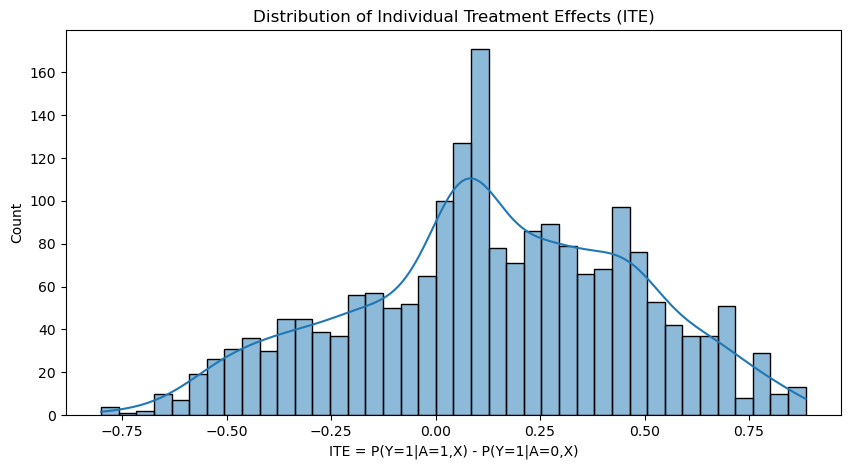

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(df['ITE'], bins=40, kde=True)
plt.title("Distribution of Individual Treatment Effects (ITE)")
plt.xlabel("ITE = P(Y=1|A=1,X) - P(Y=1|A=0,X)")
plt.ylabel("Count")
plt.show()

The ITE distribution shows a wide spread, with some players having negative effects and others having strong positive effects. This means the impact of hard levels varies greatly across players. In other words, some players are more sensitive to difficulty than others. It also suggests that difficulty adjustments should consider different player types rather than applying a single design to everyone.

### Post-Treatment Behavioral Clustering

After estimating the individual treatment effects (ITE), we apply K-Means clustering to the post-treatment gameplay behavior variables (e.g., attempts, time played, boosters used, ads lives, completion time). These features capture how players behave after experiencing the level, and clustering them allows us to group players with similar behavioral patterns.

In [15]:
post_treat_cols = [
    'attempts',
    'time_played',
    'level_completion_time',
    'booster_used',
    'lives_from_ads',
    'guild_chat_messages'
]

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cluster_data = df[post_treat_cols].copy()

scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_scaled)

print(df.groupby('cluster')['ITE'].mean())


cluster
0    0.165044
1    0.121000
2    0.135593
Name: ITE, dtype: float64


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [16]:
cluster_profile = df.groupby('cluster')[post_treat_cols].mean()
print(cluster_profile)

           attempts   time_played  level_completion_time  booster_used  \
cluster                                                                  
0         99.369863   9727.688356            1390.345890     37.051370   
1        307.036735  13515.273469             347.285714     32.875510   
2         43.745484  12724.399836             239.091133     24.425287   

         lives_from_ads  guild_chat_messages  
cluster                                       
0             12.729452            24.750000  
1             10.822449            20.930612  
2              7.639573            22.529557  


The clustering results reveal three distinct player groups with clear behavioral differences. Cluster 0 (Sensitive Socializers) shows the highest probability of churn (ITE = 0.165). They have the longest level-completion time and are highly social. Cluster 1 (Determined Competitors) has a relatively high number of attempts (307) but the lowest social frequency. With the lowest ITE (0.121), they are the least affected by hard levels. Cluster 2 (Relaxed Wanderers) demonstrates the lowest effort—only 44 attempts and minimal booster usage (24)—yet achieves the fastest level-completion time (239 seconds). They show moderate sensitivity (ITE = 0.136).

Overall, these patterns indicate that hard levels affect player segments very differently: Determined Competitors remain resilient, Relaxed Wanderers are moderately impacted, and Sensitive Socializers are the most vulnerable to churn when encountering difficult levels.

# Conclusion

Our analysis demonstrates that hard levels increase churn probability by roughly 13 percentage points. However, the distribution of Individual Treatment Effects (ITE) reveals strong heterogeneity; specifically, some players are highly sensitive to level difficulty while others are barely affected. Notably, the “Sensitive Socializers” cluster shows the highest churn response to difficulty spikes (ITE = 0.165). Implicitly, their strong social engagement means negative experiences may spread more easily through social channels, potentially discouraging additional users from participating. Therefore, we should interpret media or community comments fairly and avoid letting the opinions of a small group dominate the narrative. The best approach is to conduct a comprehensive analysis to uncover deeper insights. Game design may then focus on adaptive difficulty, timely assistance, and personalized support for this high-risk group to help reduce churn and maximize business impact.